In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.mplot3d
import mpl_toolkits.axes_grid1 as plt_ax
import scipy.stats
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold
%matplotlib inline

def scatter(data, ax=None, enum=False, title='', labels=None, legend=False, colorbar=False, xlim=None, **kwargs):
    axes_defined = ax != None
    if not axes_defined:
        fig, ax = plt.subplots(1, 1, figsize=(13, 4))
    scattered = None
    if enum:
        scattered = ax.scatter(range(len(data)), data, **kwargs)
    else:
        mapping = np.array(data).T
        scattered = ax.scatter(mapping[0], mapping[1], **kwargs)
    if labels:
        ax.set_xlabel(labels[0])
        if (len(labels) > 1):
            ax.set_ylabel(labels[1])
    if legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    if xlim:
        ax.set_xlim(xlim)
    ax.set_title(title)
    ax.grid(True)
    if colorbar:
        cax = plt_ax.make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scattered, cax=cax)
        cbar.set_ticks([-1, 0, 1])
    if not axes_defined:
        fig.tight_layout()
    return ax

def scatter_set(data1, data2, titles=['Training set', 'Validation set']):
    min_ = min(np.concatenate([data1[:, 2], data2[:, 2]]))
    max_ = max(np.concatenate([data1[:, 2], data2[:, 2]]))
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))
    for data, ax, title in zip([data1, data2], axes, titles):
        dataX = data[:, :2]
        dataY = data[:, 2]
        scatter(dataX, ax, c=dataY, vmin=min_, vmax=max_, s=np.sqrt(dataY / max_) * 100, title=title)

def plot_validation_img(set_, ax, pred=False):
    img = ax.imshow(set_, extent=[-40, 40, -35, 35], aspect='auto')
    cax = plt_ax.make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
    cbar = plt.colorbar(img, cax=cax)
    ax.set_ylabel('x1')
    ax.set_xlabel('x2')

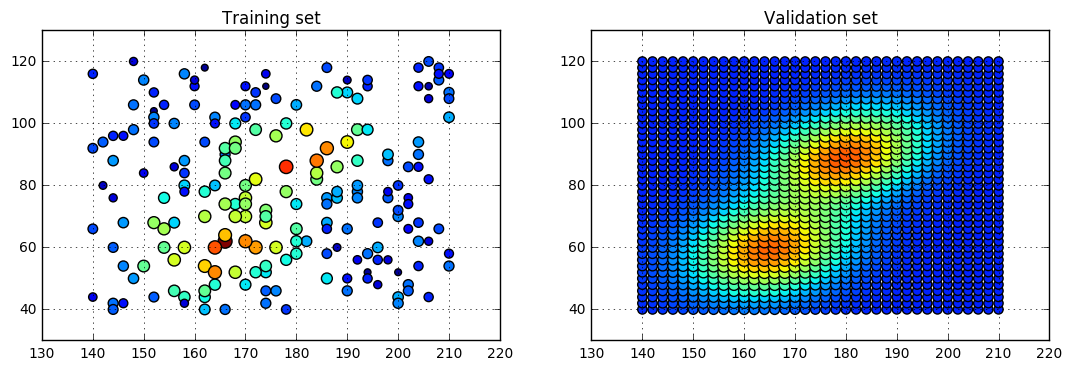

In [3]:
# Array of 200 observations {x_n, y_n} with x_n = [x_n_1, x_n_2]
training_ridge = np.loadtxt('TrainingRidge.csv', skiprows=1, dtype=bytes, delimiter=',').astype(np.float64)
# Array of 1476 combinations for [x_n_1, x_n_2] (36 x 41 grid) in same format
validation_ridge = np.loadtxt('ValidationRidge-Y.csv', skiprows=1, dtype=bytes, delimiter=',').astype(np.float64)
validation_set = validation_ridge[:, 2].reshape(41, 36).T
scatter_set(training_ridge, validation_ridge)

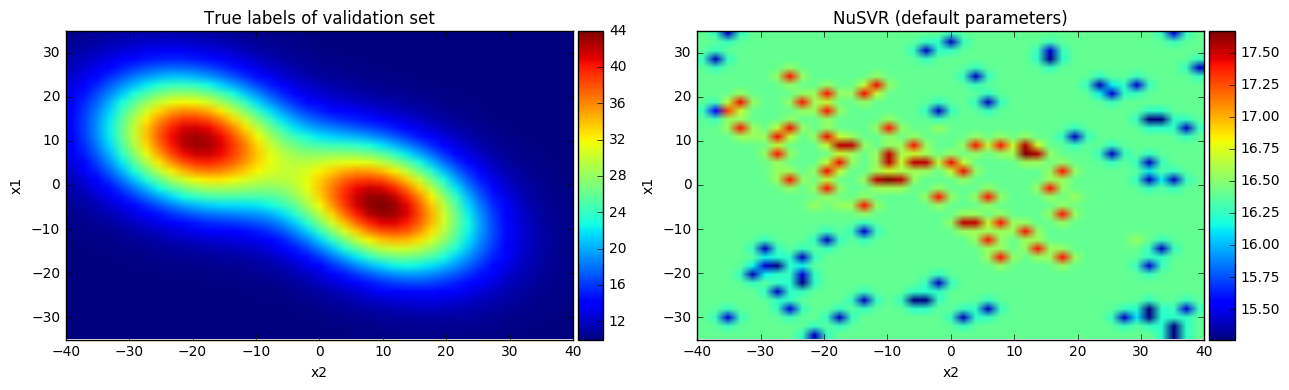

In [6]:
def svr(**kwargs):
    clf = svm.NuSVR(**kwargs)
    clf.fit(training_ridge[:, :2], training_ridge[:, 2])
    # Required shape for heatmap: 36, 41
    return clf.predict(validation_ridge[:, :2]).reshape(41, 36).T
    
# 2.a)
naive_preds = svr()
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
plot_validation_img(validation_set, ax[0])
ax[0].set_title('True labels of validation set')
plot_validation_img(naive_preds, ax[1])
ax[1].set_title('NuSVR (default parameters)')
fig.tight_layout()

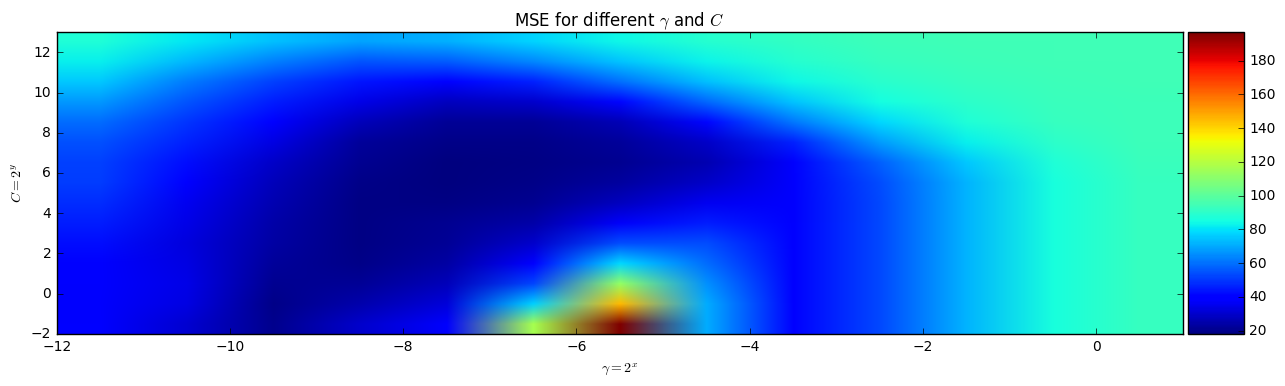

In [129]:
# 2.b: 10-fold cross validation
X = training_ridge[:, :2]
Y = training_ridge[:, 2]
C = np.power(2.0, np.arange(-2, 13))
Gamma = np.power(2.0, np.arange(-12, 1))
results = []
kf = KFold(len(Y), 10)  # 10 folds
for c in C:
    c_results = []
    for g in Gamma:
        scores = []
        for train_i, test_i in kf:
            clf = svm.NuSVR(kernel='rbf', nu=0.5, C=c, gamma=g)
            clf.fit(X[train_i], Y[train_i])
            preds = clf.predict(X[test_i, :])
            scores.append(metrics.mean_squared_error(preds, Y[test_i]))
        c_results.append(np.mean(scores))
    results.append(c_results)
fig, ax = plt.subplots(1, 1, figsize=(13, 4))
# x axis: gamma, y axis: C
img = ax.imshow(results, extent=[-12, 1, -2, 13], aspect='auto')
cax = plt_ax.make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(img, cax=cax)
ax.set_ylabel(r'$C = 2^y$')
ax.set_xlabel(r'$\gamma = 2^x$')
ax.set_title(r'MSE for different $\gamma$ and $C$')
fig.tight_layout()

In [24]:
# metrics: mean_squared_error, make_scorer
# 2.c: Find best parameters
param_grid = {
    'C': np.power(2.0, np.arange(-2, 13)),
    'gamma': np.power(2.0, np.arange(-12, 1))
}
grid_clf = GridSearchCV(svm.NuSVR(kernel='rbf', nu=0.5), param_grid, cv=10, scoring='neg_mean_squared_error')
grid_clf.fit(training_ridge[:, :2], training_ridge[:, 2])
best_params = grid_clf.best_params_

print('Best parameters for v-SVR: C={:4.4f} and gamma={:4.4f}'.format(best_params['C'], best_params['gamma']))
print('Best cross validation scores {:4.4f}'.format(-grid_clf.best_score_))

best_preds = grid_clf.best_estimator_.predict(validation_ridge[:, :2]).reshape(41, 36).T
naive_preds = svr()

Best parameters for v-SVR: C=16.0000 and gamma=0.0039
Best cross validation scores 18.0978


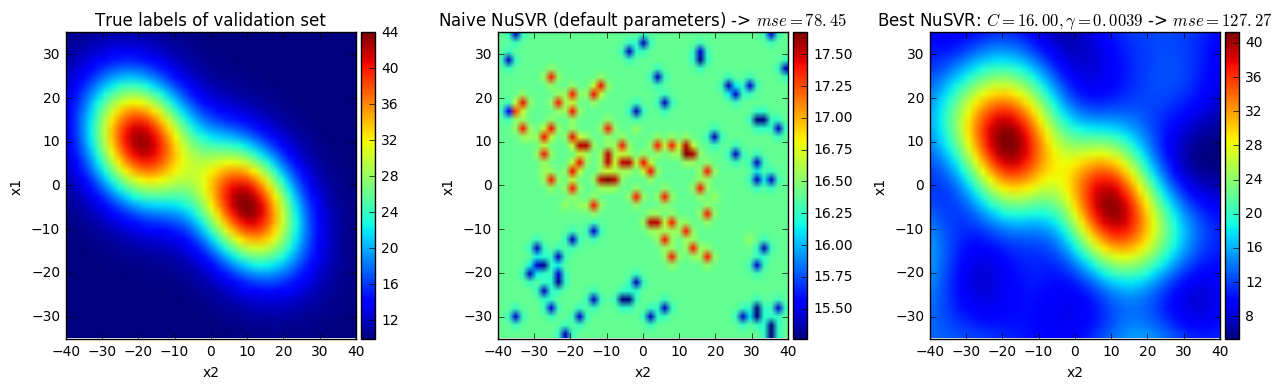

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
plot_validation_img(validation_set, ax[0])
ax[0].set_title('True labels of validation set')
plot_validation_img(naive_preds, ax[1])
ax[1].set_title(r'Naive NuSVR (default parameters) -> $mse = {:4.2f}$'.format(
    metrics.mean_squared_error(naive_preds.flatten(), validation_ridge[:, 2])))
plot_validation_img(best_preds, ax[2])
ax[2].set_title(r'Best NuSVR: $C = {:4.2f} , \gamma = {:4.4f}$ -> $mse = {:4.2f}$'.format(
    best_params['C'], best_params['gamma'], metrics.mean_squared_error(best_preds.flatten(), validation_ridge[:, 2])))
fig.tight_layout()